## Use climate data to show impact on extreme events of small mean changes

### Read in data from NOAA (https://www.noaa.gov/)

In [1]:
import pandas as pd
df = pd.read_csv('ny_maxtemp_and_precip-1970.csv')

# convert string dates
df['DATE'] = pd.to_datetime(df['DATE'])

### Filter to select only high temperatures for each August day from 1970 through 2009

In [29]:
idx = df['DATE'].map(lambda x: x.month == 8) & (df['DATE'] < pd.to_datetime('2009/12/31'))
aug_tmps = df[idx]['TMAX']

# get summary statistics from the data
mu = aug_tmps.mean()
sigma = aug_tmps.std()
scale = aug_tmps.count()

print('{} data points:'.format(scale))
print('min:     {:0.1f}'.format(aug_tmps.min()))
print('max:     {:0.1f}'.format(aug_tmps.max()))
print('mean:    {:0.1f}'.format(mu))
print('median:    {:0.1f}'.format(aug_tmps.median()))
print('std dev: {:0.1f}'.format(sigma))

1240 data points:
min:     60.0
max:     100.0
mean:    82.2
median:    82.0
std dev: 5.6


### The distribution looks roughly normal

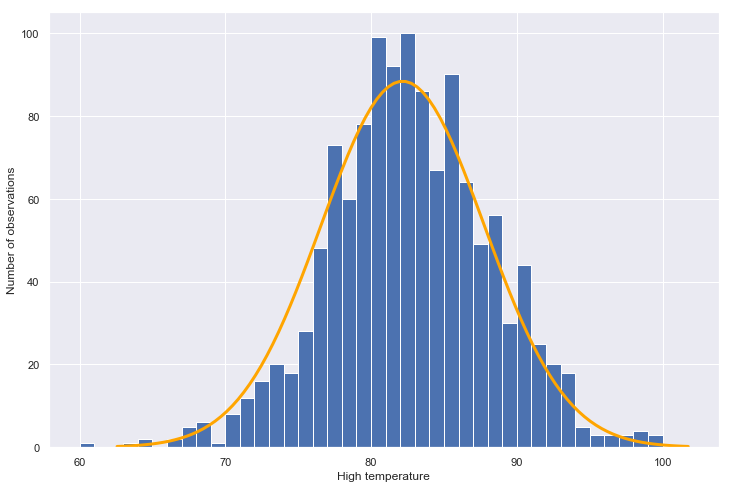

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import numpy as np
import scipy.stats as stats
import math

# plot a histogram of the August temperatures

# ... one bin per degree in range of temperature
bin_count = int(aug_tmps.max() - aug_tmps.min())

# ... plot histogram
plt.figure(figsize=(12, 8))
plt.hist(aug_tmps, bins=bin_count)

# plot MLE normal distribution, using summary statistics
x = np.linspace(mu - 3.5 * sigma, mu + 3.5 * sigma, 100)
plt.plot(x, scale * stats.norm.pdf(x, mu, sigma), c='orange', linewidth=3)

plt.xlabel('High temperature')
plt.ylabel('Number of observations');


### Define what we mean by "extreme"

In [4]:
scorcher = 99

# MLE probability of a scorcher given the NOAA data (assuming the distribution is, in fact, normal)
baseline_scorcher_prob = 1 - stats.norm.cdf(scorcher, mu, sigma)

In [38]:
# probability of a scorcher at +2 degrees mean
p = 1 - stats.norm.cdf(scorcher, mu + 2, sigma)

print("baseline scorcher probability: {:0.2f}%".format(100 * baseline_scorcher_prob))
print("new scorcher probability:      {:0.2f}%".format(100 * p))
print("number of times more likely:   {:0.2f}".format(p/baseline_scorcher_prob))

baseline scorcher probability: 0.13%
new scorcher probability:      0.40%
number of times more likely:   3.05


### Look at how small changes to the mean daily high affect the probability of scorchers

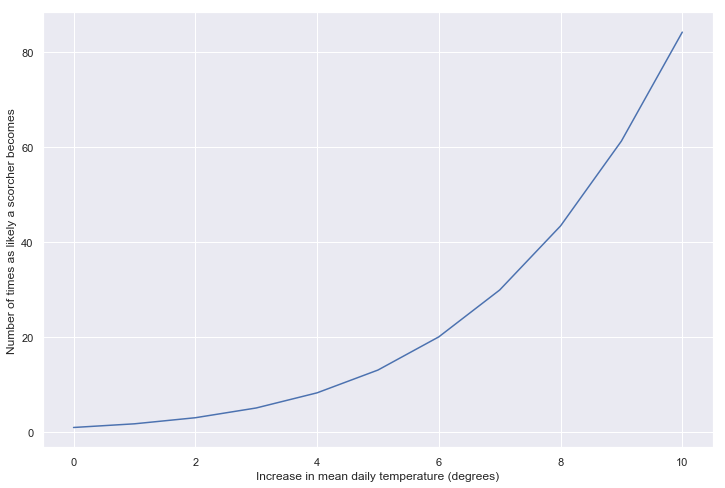

In [5]:
# Graph increase in probability of a scorcher vs. number of degrees the mean increases
plt.figure(figsize=(12, 8))
x = np.arange(0, 11)
plt.plot(x, (1 - stats.norm.cdf(scorcher, mu + x, sigma)) / baseline_scorcher_prob)
plt.xlabel('Increase in mean daily temperature (degrees)')
plt.ylabel('Number of times as likely a scorcher becomes');

### Low extremes also becomes exponentially less likely

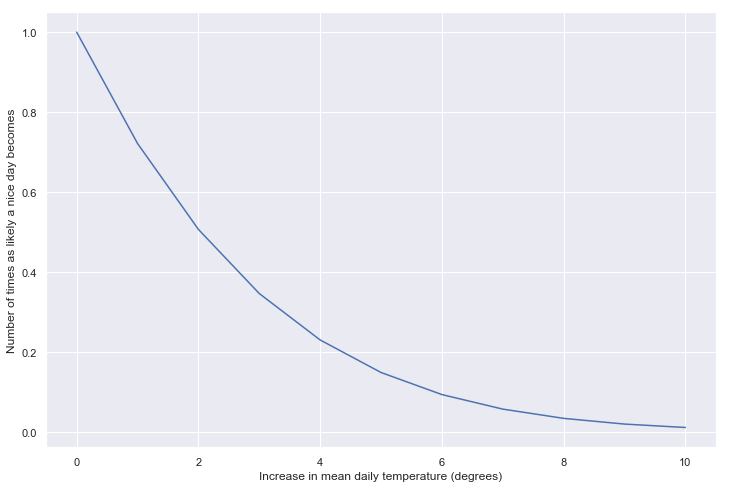

In [6]:
# define an unseasonably nice day
nice_day = 75

# probability of a nice day, given the NOAA data (and assuming the distribution is normal)
baseline_nice_day_prob = stats.norm.cdf(nice_day, mu, sigma)

# graph decrease in probability of nice days, as mean temperature rises
plt.figure(figsize=(12, 8))
x = np.arange(0, 11)
plt.plot(x, stats.norm.cdf(nice_day, mu + x, sigma) / baseline_nice_day_prob)

plt.xlabel('Increase in mean daily temperature (degrees)')
plt.ylabel('Number of times as likely a nice day becomes');

## Why this happens

### Plot before and after distributions with small change in mean temperature

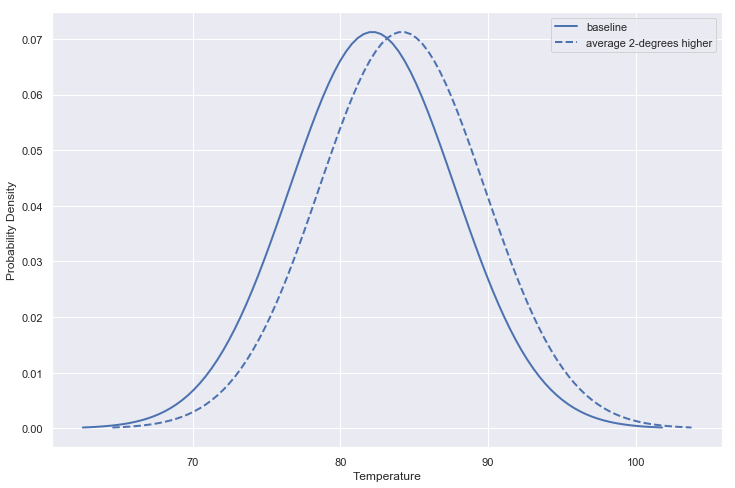

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import numpy as np
import scipy.stats as stats
import math

plt.figure(figsize=(12, 8))

# plot baseline normal distribution 
x = np.linspace(mu - 3.5*sigma, mu + 3.5*sigma, 100)
plt.plot(x, 
         stats.norm.pdf(x, mu, sigma), 
         c='b', linewidth=2,
         label='baseline'
        )

# plot distribution, given a 2 degree increase in the mean
new_mu = mu + 2
x = np.linspace(new_mu - 3.5*sigma, new_mu + 3.5*sigma, 100)
plt.plot(x,
         stats.norm.pdf(x, new_mu, sigma), 
         c='b', linewidth=2, linestyle='--',
         label='average 2-degrees higher'
        )

plt.xlabel('Temperature')
plt.ylabel('Probability Density')

plt.legend();

### Zoom in on just the right tail of the distribution, to see what's happening to extreme event probability

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import numpy as np
import scipy.stats as stats
import math


def plot_tail_of_temp_increase_distribution(mu, sigma, extreme_boundary, temp_increase):
    '''
    Plots just the right hand tail of a distribution to show how much the
    probability of extreme events increases with a small change in the mean
    
    mu, sigma - parameters of the baseline normal distribution
    extreme_boundary - level greater than which events are considered "extreme"
    temp_increase - The amount by which the temperature increases
    '''
    
    plt.figure(figsize=(12, 8))

    # number of points on x-axis
    granularity = 100

    # scope of graph
    min_temp = extreme_boundary - 1

    # left-hand boundary for marking area under curve (same for both distributions)
    fill_left = (extreme_boundary - mu) / sigma

    # plot baseline distribution

    # ... scope of graph (right side depends on distribution)
    max_temp = mu + temp_increase + 4*sigma
    x = np.linspace(min_temp, max_temp, granularity)

    # ... left-hand boundary for marking area under curve
    baseline_fill_offset = int(100 / (max_temp - min_temp))

    # ... plot distribution
    plt.plot(x, 
             stats.norm.pdf(x, mu, sigma), 
             linewidth=2, c='b',
             label='baseline'
            )

    # plot distribution with increased mean

    new_mu = mu + temp_increase

    # ... scope of graph (right side depends on distribution)
    max_temp = new_mu + 4 * sigma
    x = np.linspace(min_temp, max_temp, granularity)

    # ... left-hand boundary for marking area under curve
    new_fill_offset = int(100 / (max_temp - min_temp))

    # ... plot distribution with increased mean
    plt.plot(x,
             stats.norm.pdf(x, new_mu, sigma), 
             linewidth=2, c='b', linestyle='--',
             label='average {}-degrees higher'.format(temp_increase)
            )

    # calculate area under curve for legend
    baseline_prob = 100 * (1 - stats.norm.cdf(scorcher, mu, sigma))
    additional_prob = 100 * (1 - stats.norm.cdf(scorcher, mu + temp_increase, sigma)) - baseline_prob

    # fill in original area under curve
    xx = x[baseline_fill_offset:]
    plt.fill_between(xx,
                     stats.norm.pdf(xx, mu, sigma), 
                     color='b', alpha=0.75,
                     label = '{:0.2f}%'.format(baseline_prob)
                    )

    # fill in additional area under curve
    xx = x[new_fill_offset:]
    plt.fill_between(xx, 
                     stats.norm.pdf(xx, mu, sigma), 
                     stats.norm.pdf(xx, new_mu, sigma), 
                     alpha=0.5,
                     label = '{:0.2f}% higher'.format(additional_prob)
                    )

    plt.xlabel('Temperature')
    plt.ylabel('Probability Density')

    plt.legend();
    

### 2-degree increase in mean temperature slightly more than doubles the scorcher probability

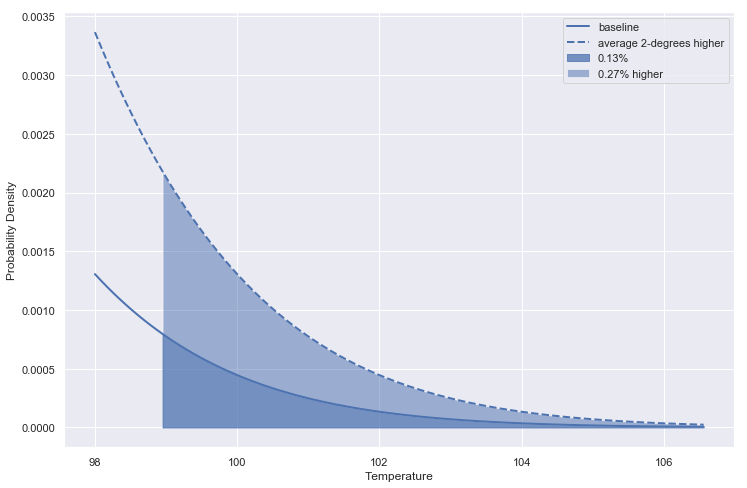

In [26]:
plot_tail_of_temp_increase_distribution(mu, sigma, scorcher, 2)

### At 5-degrees higher, the probability of a scorcher increases by more than 10x

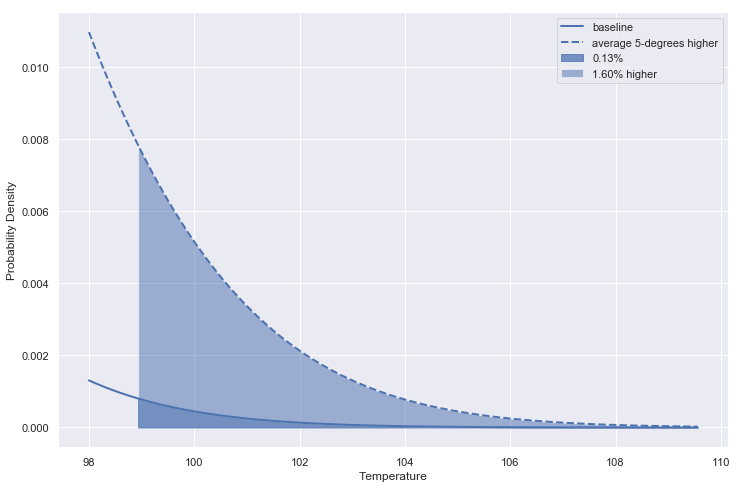

In [27]:
plot_tail_of_temp_increase_distribution(mu, sigma, scorcher, 5)

### At a 10-degree higher mean, the probability is almost 100 times higher

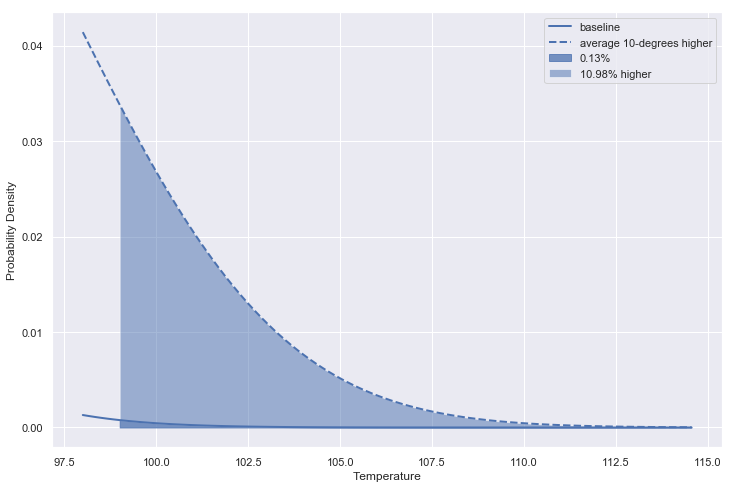

In [28]:
plot_tail_of_temp_increase_distribution(mu, sigma, scorcher, 10)